(340, 41)
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.3044 - val_loss: 0.0114
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0132 - val_loss: 0.0092
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0052 - val_loss: 0.0120
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0048 - val_loss: 0.0105
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0052 - val_loss: 0.0101
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0046 - val_loss: 0.0103
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0047 - val_loss: 0.0103
Epoch 8/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0039 - val_loss: 0.0097
Epoch 9/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0040 - val_loss: 0.0099
Epoch 10/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0045 - val_loss: 0.0106
Epoch 11/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0039 - val_loss: 0.0113
Epoch 12/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0052 - val_loss: 0.0088

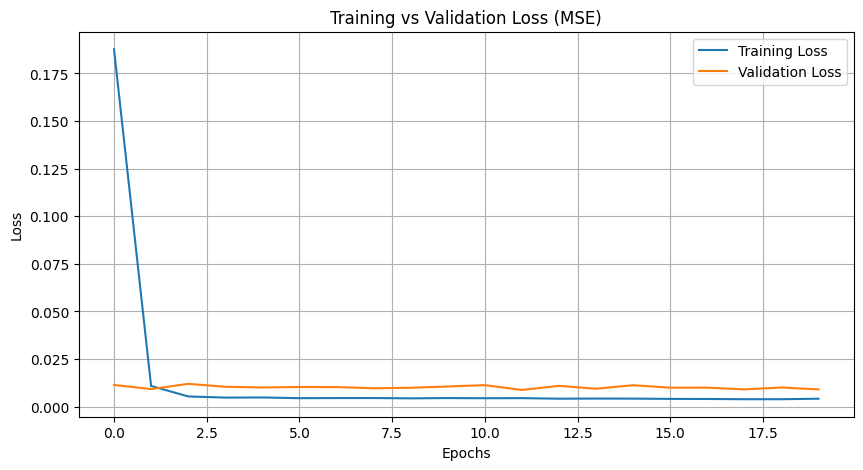

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step

📊 Test MSE: 14.1024
📏 Test RMSE: 3.7553
📈 Test R² Score: 0.7354


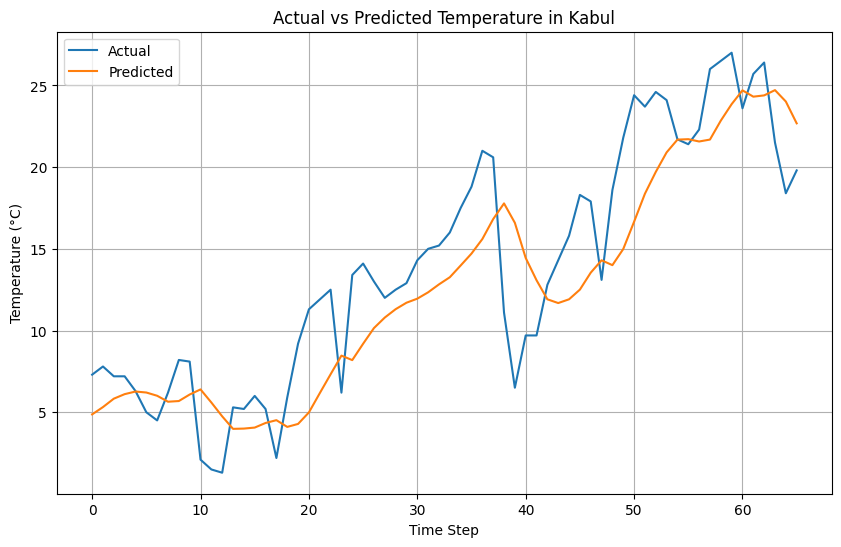

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step

🔮 Predicted Next Temperature in Kabul: 21.84°C


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense
import math

# Step 1: Load Data
df = pd.read_csv('GlobalWeatherRepository.csv')

# Step 2: Filter data for one city (e.g., Kabul)
city_df = df[df['location_name'] == 'Kabul'].copy()
print(city_df.shape)

# Step 3: Convert date and sort
city_df['last_updated'] = pd.to_datetime(city_df['last_updated'])
city_df.sort_values('last_updated', inplace=True)

# Step 4: Use only temperature
temp = city_df[['temperature_celsius']].values

# Step 5: Normalize data
scaler = MinMaxScaler()
temp_scaled = scaler.fit_transform(temp)

# Step 6: Create sequences
def create_sequences(data, time_steps=10):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
        # print(X)
    return np.array(X), np.array(y)

X, y = create_sequences(temp_scaled, time_steps=10)

# Step 7: Train-Test Split
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Step 8: Build LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(X.shape[1], 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# Step 9: Train and get history
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=8,
    validation_data=(X_test, y_test),
    verbose=1
)

# Step 10: Plot Training vs Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Step 11: Predictions on Test Set
y_pred_scaled = model.predict(X_test)
y_test_actual = scaler.inverse_transform(y_test)
y_pred_actual = scaler.inverse_transform(y_pred_scaled)

# Step 12: Custom Accuracy Calculation
def regression_accuracy(y_true, y_pred, tolerance=2.0):
    correct = np.sum(np.abs(y_true - y_pred) <= tolerance)
    total = len(y_true)
    return correct / total * 100

mse = mean_squared_error(y_test_actual, y_pred_actual)
rmse = math.sqrt(mse)
r2 = r2_score(y_test_actual, y_pred_actual)


# Print Evaluation
print(f"\n📊 Test MSE: {mse:.4f}")
print(f"📏 Test RMSE: {rmse:.4f}")
print(f"📈 Test R² Score: {r2:.4f}")


# Step 13: Plot Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label='Actual')
plt.plot(y_pred_actual, label='Predicted')
plt.xlabel("Time Step")
plt.ylabel("Temperature (°C)")
plt.title("Actual vs Predicted Temperature in Kabul")
plt.legend()
plt.grid(True)
plt.show()

# Step 14: Predict Future Temperature
last_seq = temp_scaled[-10:]
future_input = last_seq.reshape((1, 10, 1))
future_pred_scaled = model.predict(future_input)
future_pred = scaler.inverse_transform(future_pred_scaled)

print(f"\n🔮 Predicted Next Temperature in Kabul: {future_pred[0][0]:.2f}°C")
